This project uses articles from TechCrunch from 2010 to 2016 to conduct Natural Languages Processing analysis.

### Import the packages

In [39]:
import pandas as pd
import numpy as np
import re
import nltk
import pickle
from collections import Counter
from collections import OrderedDict
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import sent_tokenize
from nltk.tokenize import TreebankWordTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score
%matplotlib inline

In [4]:
pd.options.display.max_columns = 100

### Import the data

In [5]:
raw = pd.read_csv('techcrunch_posts.csv')

In [6]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39115 entries, 0 to 39114
Data columns (total 11 columns):
authors     38815 non-null object
category    38393 non-null object
content     39061 non-null object
date        39115 non-null object
id          39115 non-null int64
img_src     39115 non-null object
section     39115 non-null object
tags        34148 non-null object
title       39115 non-null object
topics      5604 non-null object
url         39115 non-null object
dtypes: int64(1), object(10)
memory usage: 3.3+ MB


In [7]:
# Drop the articles without contents

df = raw[pd.notnull(raw['content'])]

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39061 entries, 0 to 39114
Data columns (total 11 columns):
authors     38761 non-null object
category    38339 non-null object
content     39061 non-null object
date        39061 non-null object
id          39061 non-null int64
img_src     39061 non-null object
section     39061 non-null object
tags        34097 non-null object
title       39061 non-null object
topics      5590 non-null object
url         39061 non-null object
dtypes: int64(1), object(10)
memory usage: 3.6+ MB


In [9]:
# Fill null values

df[['category']].fillna('none', inplace = True)

//anaconda/lib/python3.5/site-packages/pandas/core/frame.py:2762: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


### Exploratory Data Analysis

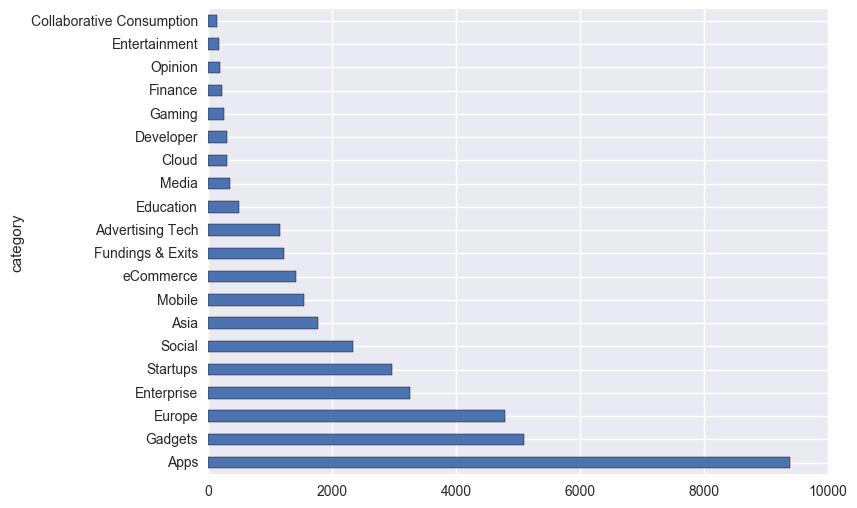

In [10]:
# Plot the categories

categories = df.groupby('category')['id'].count()
categories = categories.sort_values(ascending = False)[:20]

categories.plot(kind = 'barh', figsize=(8, 6))

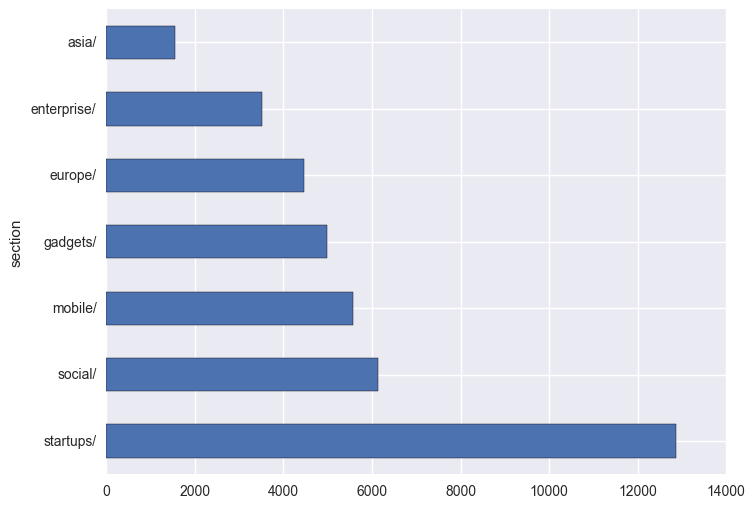

In [11]:
# Plot the sections

sections = df.groupby('section')['id'].count()
sections = sections.sort_values(ascending = False)[:20]

sections.plot(kind = 'barh', figsize=(8, 6))

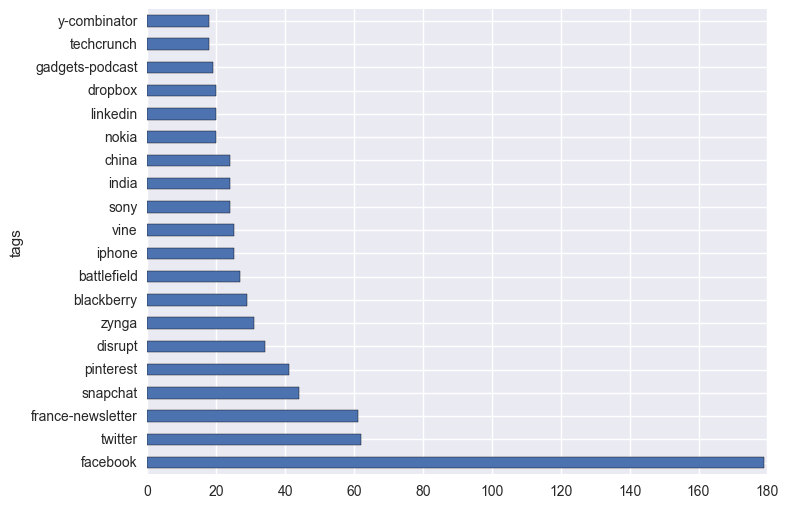

In [12]:
# Plot the tags

tags = df.groupby('tags')['id'].count()
tags = tags.sort_values(ascending = False)[:20]

tags.plot(kind = 'barh', figsize=(8, 6))

#### WordCloud

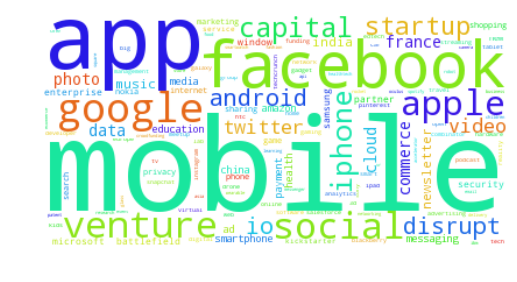

In [13]:
#Word Cloud for tags(without word size weights)
list_of_tags = [str(t) for t in df['tags']]
list_of_tags_combined = ' '.join(list_of_tags)
list_of_tags_combined = list_of_tags_combined.replace('nan', '')

cloud_text = list_of_tags_combined

wordcloud = WordCloud(stopwords=STOPWORDS, background_color = 'white').generate(cloud_text)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### Process the article content by removing punctuation, convert words to lower case, remove stop words and stemming.

In [14]:
def process_content(data):
    
    # Keep only the words, remove punctuations
    formatted_content = re.sub("[^a-zA-Z]", " ", data)
    
    # Convert all words to lower case and split into a list
    words = formatted_content.lower().split()
    
    # List of stop words
    stop = stopwords.words('english')
    
    # Produce a list of clean words that does not appear in stop words
    clean_words = [w for w in words if w not in stop]
    
    # Stemming
    stemmer = nltk.stem.porter.PorterStemmer()
    stem_clean_words = [stemmer.stem(w) for w in clean_words if w not in stop]

    return " ".join(stem_clean_words)

In [15]:
# Create a list of clean contents, later uses pickle file

'''
complete_clean_content = []
for article in df['content']:
    complete_clean_content.append(process_content(article))
'''

In [16]:
len(complete_clean_content)

39061

In [20]:
# Save complete list of contents into pickle file

pd.to_pickle(complete_clean_content, 'content.pkl')

In [21]:
contents = pd.read_pickle('content.pkl')

#### Create a Count Matrix

In [22]:
# Count Matrix for top 1000 words, excluding words that appear in fewer than 5 articles and more than 90% of articles

cv = CountVectorizer(ngram_range=(1,1), min_df=5, max_df = 0.9, max_features=1000, stop_words='english')

# Fit the vectorizer with article content
cv.fit(contents)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9, max_features=1000, min_df=5,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [23]:
# Call transform to convert into bag of words

x_cv = cv.transform(contents)

In [24]:
print('Matrix')
x_back_cv = x_cv.toarray()
print(x_back_cv)

Matrix
[[0 0 0 ..., 0 0 0]
 [1 1 0 ..., 0 0 0]
 [2 1 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


In [32]:
pd.DataFrame(x_back_cv, columns=cv.get_feature_names()).head()

,abil,abl,acceler,accept,access,accord,account,achiev,acquir,acquisit,act,action,activ,actual,ad,add,addit,address,adopt,advanc,advantag,advertis,afford,age,agenc,aggreg,ago,ahead,aim,air,alert,algorithm,allow,alon,alreadi,altern,alway,amazon,america,american,analyt,android,angel,announc,anoth,answer,anyon,anyth,api,app,...,upgrad,upload,usag,use,user,usual,valley,valu,valuat,variou,vc,ventur,version,video,view,virtual,vision,visit,visual,voic,vr,wait,wall,want,watch,way,wearabl,web,websit,week,went,whatev,whatsapp,wide,wider,win,window,women,word,work,world,worth,write,wrote,yahoo,ye,year,york,young,youtub
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,3,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,2,0,0,5,4,0,0,0,1,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,0,0,0,0,0,7,0,0,0
2,2,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,...,0,0,0,2,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,5,0,0,0
4,0,0,0,0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,...,0,0,0,4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0


#### Create a TD-IDF Matrix

In [25]:
# TF-IDF Matrix for top 1000 words, excluding words that appear in fewer than 5 articles and more than 90% of articles

tfidf = TfidfVectorizer(ngram_range=(1,1), min_df=5, max_df = 0.9, max_features=1000, stop_words='english')
x_tfidf = tfidf.fit_transform(contents)

In [26]:
print('Matrix')
x_back_tfidf = x_tfidf.toarray()
print(x_back_tfidf)

Matrix
[[ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.02625722  0.02157871  0.         ...,  0.          0.          0.        ]
 [ 0.09315802  0.03827956  0.         ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]]


In [31]:
pd.DataFrame(x_back_tfidf, columns=tfidf.get_feature_names()).head()

,abil,abl,acceler,accept,access,accord,account,achiev,acquir,acquisit,act,action,activ,actual,ad,add,addit,address,adopt,advanc,advantag,advertis,afford,age,agenc,aggreg,ago,ahead,aim,air,alert,algorithm,allow,alon,alreadi,altern,alway,amazon,america,american,analyt,android,angel,announc,anoth,answer,anyon,anyth,api,app,...,upgrad,upload,usag,use,user,usual,valley,valu,valuat,variou,vc,ventur,version,video,view,virtual,vision,visit,visual,voic,vr,wait,wall,want,watch,way,wearabl,web,websit,week,went,whatev,whatsapp,wide,wider,win,window,women,word,work,world,worth,write,wrote,yahoo,ye,year,york,young,youtub
0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.03177,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.054981,0.039077,0.0,0.00000,0.0,0.0,0.0,0.000000,0.00000,0.00000,0.0,0.041238,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.030061,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.056094,0.0,0.0,0.000000,0.000000,0.0,0.0,0.096709,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.024009,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
1,0.026257,0.021579,0.0,0.000000,0.000000,0.000000,0.025653,0.000000,0.0,0.000000,0.0,0.000000,0.046236,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.052341,0.0,0.00000,0.0,0.0,0.0,0.000000,0.06978,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.030687,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.034691,0.054256,0.0,0.0,0.161919,0.088774,0.0,0.0,0.0,0.032348,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.032158,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.03337,0.0,0.0,0.063359,0.0,0.000000,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.097629,0.000000,0.0,0.0
2,0.093158,0.038280,0.0,0.062466,0.000000,0.000000,0.045506,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.000000,0.00000,0.00000,0.0,0.097985,0.0,0.0,0.0,0.0,0.0,0.0,0.034191,0.000000,0.0,0.054438,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.022214,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.027007,0.0,0.0,0.0,0.038195,0.05694,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.047071,0.0253,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
3,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.040025,0.000000,0.0,0.043626,0.0,0.000000,0.036071,0.00000,0.0,0.0,0.100334,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.040833,0.0,0.00000,0.0,0.0,0.0,0.030153,0.00000,0.02944,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.031412,0.0,0.000000,0.0,0.0,0.023419,...,0.0,0.0,0.0,0.039077,0.0,0.0,0.000000,0.042328,0.0,0.0,0.000000,0.069257,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025088,0.0,0.023754,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0000,0.031622,0.0,0.0,0.0,0.0,0.0,0.108807,0.000000,0.0,0.0
4,0.000000,0.000000,0.0,0.000000,0.028316,0.029554,0.000000,0.045264,0.0,0.000000,0.0,0.040253,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.03304,0.0,0.0,0.0,0.000000,0.00000,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.038293,...,0.0,0.0,0.0,0.063896,0.0,0.0,0.000000,0.034606,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.116922,0.0,0.0


#### PCA

In [33]:
# PCA using SVD - 500 components

reducer = PCA(n_components = 500)
reduced_X = reducer.fit_transform(x_back_tfidf)

sum(reducer.explained_variance_ratio_)

0.79206797523543804

In [34]:
# PCA using SVD - 200 components

reducer = PCA(n_components = 200)
reduced_X = reducer.fit_transform(x_back_tfidf)

sum(reducer.explained_variance_ratio_)

0.54028464913047491

In [207]:
# PCA using Truncated SVD - 500 components

reducer_svd = TruncatedSVD(n_components = 500)
reduced_X_svd = reducer_svd.fit_transform(x_back_tfidf)

sum(reducer_svd.explained_variance_ratio_)

0.95909531068416987

In [35]:
# PCA using Truncated SVD - 200 components

reducer_svd = TruncatedSVD(n_components = 200)
reduced_X_svd = reducer_svd.fit_transform(x_back_tfidf)

sum(reducer_svd.explained_variance_ratio_)

0.54195728832294421

#### K-means Clustering using TF-IDF

In [36]:
num_clusters = 10

km = KMeans(n_clusters=num_clusters)

%time km.fit(reduced_X)

clusters = km.labels_.tolist()

CPU times: user 44.7 s, sys: 1.62 s, total: 46.3 s
Wall time: 27.8 s


In [37]:
Counter(clusters)

Counter({0: 4603,
         1: 5353,
         2: 1952,
         3: 1143,
         4: 923,
         5: 3574,
         6: 7235,
         7: 1571,
         8: 9633,
         9: 3074})

In [ ]:
silhouette_score(reduced_X, clusters)

In [ ]:
# Plot number of cluster vs silhouette score

num_clusters_range = range(100)



#### Agglomerative Hierarchical Clustering using TF-IDF

In [ ]:
num_cluster = 10

ah = AgglomerativeClustering(n_cluster = num_cluster)

%time ah.fit(reduced_X)

clusters_ah = ah.labels_.tolist()

In [ ]:
Counter(clusters_ah)

In [ ]:
silhouette_score(reduced_X, clusters_ah)

#### Topic Modeling

#### Word2Vec

#### Recommender

Recommend articles with others that lay in the same cluster.

In [130]:
km.labels_[0]

17

In [132]:
# Function to return a list of article index that's in the same cluster

def rec_articles(index):  
    rec = []
    c = km.labels_[index]
    n = 0
    for item in km.labels_:
        if item == c:
            rec.append(n)
        n += 1
    return rec

In [138]:
rec_articles(1)

[1, 100, 649, 700, 745, 959, 962, 973]

#### Sentiment of each article

In [55]:
# Sentiment of articles

def article_sentiment(data):
    d = OrderedDict()
    n = 1
    article_sentiment = OrderedDict()
    for item in data:
        d[n] = TextBlob(item).sentiment
        n += 1
    return d

In [56]:
df_sentiments = article_sentiment(df['content'])

In [66]:
df_sentiments

OrderedDict([(1,
              Sentiment(polarity=0.1521342756570029, subjectivity=0.5428042874633782)),
             (2,
              Sentiment(polarity=0.11882332643202209, subjectivity=0.4306267253278124)),
             (3,
              Sentiment(polarity=0.12646656065023412, subjectivity=0.5562402450157552)),
             (4,
              Sentiment(polarity=0.10013408521303258, subjectivity=0.5248053467000836)),
             (5,
              Sentiment(polarity=0.10025974025974027, subjectivity=0.39515151515151514)),
             (6,
              Sentiment(polarity=0.21134580617339233, subjectivity=0.45092779187606774)),
             (7,
              Sentiment(polarity=0.08636898815470241, subjectivity=0.44738555095697946)),
             (8,
              Sentiment(polarity=0.1275573192239859, subjectivity=0.3000881834215167)),
             (9,
              Sentiment(polarity=0.08790711346266902, subjectivity=0.5865196942974722)),
             (10,
              Sentiment(pol

In [40]:
# Sentence tokennizer

sentences = sent_tokenize(raw['content'][0])

In [41]:
# Word tokenizer

tokenizer = TreebankWordTokenizer()
tokenizer.tokenize(sentences[0])

['Tech',
 'investing',
 'isn’t',
 'what',
 'it',
 'used',
 'to',
 'be',
 '—',
 'even',
 'compared',
 'to',
 'six',
 'months',
 'ago',
 '.']